In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Định nghĩa dataloader

In [2]:
# Ô này tạm thời bỏ qua không quan tâm nhiều
class CMAPSSDataset(Dataset):
    def __init__(self, data, seq_len=30):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_len, :-1]
        target = self.data[idx + self.seq_len - 1, -1]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# Trong pytorch, dữ liệu phải được đưa vào một đối tượng mà pytorch có thể tự động đọc, điều này không giống trong keras do cách
# hoạt động khác nhau của mỗi framework
# FD002Dataset sẽ là nơi làm việc này, và trong này cũng miêu tả cách dữ liệu được xử lý như thế nào luôn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class FD002Dataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data # Truyền vào data frame đã được xử lý ở trên
        self.sequence_length = sequence_length # Chỉ định khung cho mỗi mẫu data, ta lấy 30 dòng để dự đoán cho dòng 30
        self.sequences = [] # Cứ mỗi lần lấy ra 30 dòng thì thêm nó vào đây
        self.targets = [] # Nhãn càn dự đoán là RUL của dòng cuối cùng được lấy ra
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


## Định nghĩa mô hình Transformer

In [4]:
# Xây dựng kiến trúc mô hình Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)


## Loading dataset and preprocessing

In [5]:
train_2 = "../data/train_FD002.txt"

In [6]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_2 = pd.read_csv(train_2, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,


In [7]:
# remaining_rul = max_rul - cycle
max_cycle = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

In [8]:
# train_2 = train_2.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [10]:
# Chuẩn hóa dữ liệu
df = train_2.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082,0.392573
1,1,2,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562,0.389920
2,1,3,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414,0.387268
3,1,4,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144,0.384615
4,1,5,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240,0.381963


## Huấn luyện mô hình với sequence_length = 50, 50 epochs

In [12]:
# Đưa dataset vào dataloader
dataset = FD002Dataset(df, sequence_length=50)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [13]:
dataset.__len__()

41019

In [14]:
train_data.__len__()

32815

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = 24
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.027043299587919116, Val Loss = 0.016924675733416345
Epoch 2: Train Loss = 0.01637164631597044, Val Loss = 0.012404405950398297
Epoch 3: Train Loss = 0.013725857689049001, Val Loss = 0.012877336614457202
Epoch 4: Train Loss = 0.012856402952037025, Val Loss = 0.011384706676064298
Epoch 5: Train Loss = 0.012169526685228967, Val Loss = 0.012728329246015748
Epoch 6: Train Loss = 0.01196802216654618, Val Loss = 0.010688713510749057
Epoch 7: Train Loss = 0.011543931517129144, Val Loss = 0.01146796175753444
Epoch 8: Train Loss = 0.011378298606405844, Val Loss = 0.011174787196479304
Epoch 9: Train Loss = 0.010948613764841625, Val Loss = 0.01098029731486558
Epoch 10: Train Loss = 0.010811145906200447, Val Loss = 0.011052893677632169
Epoch 11: Train Loss = 0.010718549987288523, Val Loss = 0.010011863246096247
Epoch 12: Train Loss = 0.010404783957111368, Val Loss = 0.011060186310269025
Epoch 13: Train Loss = 0.010341482937969557, Val Loss = 0.008872502612979206
Epoch 14: Tr

In [23]:
model.eval()
sample, _ = dataset[0]
sample = sample.unsqueeze(0).to(device)  
predicted_rul = model(sample)
print(f"Predicted RUL: {predicted_rul.item()}")

Predicted RUL: 0.3445013463497162


In [24]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [25]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


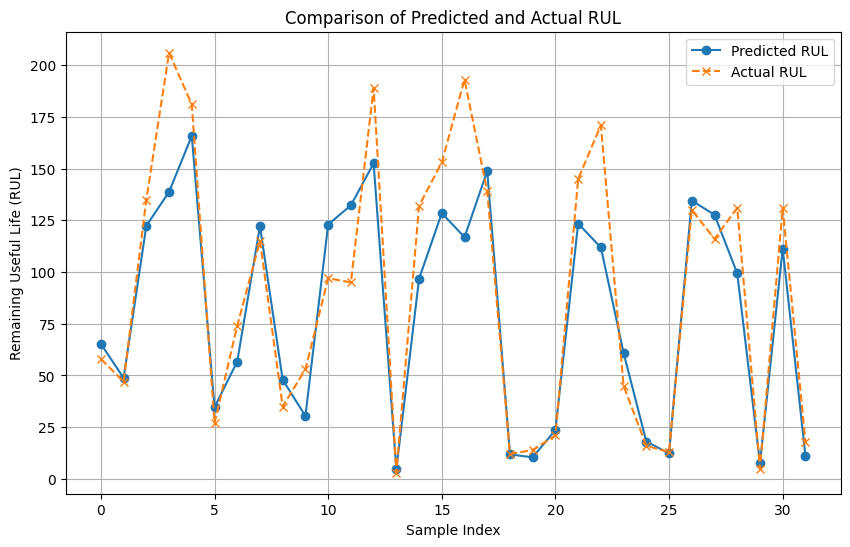

In [26]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 10, 50 epochs

In [27]:
# Đưa dataset vào dataloader
dataset = FD002Dataset(df, sequence_length=10)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD002Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.03330499189362671, Val Loss = 0.015842042976168928
Epoch 2: Train Loss = 0.017862269919927624, Val Loss = 0.01331757586622923
Epoch 3: Train Loss = 0.015313069251384788, Val Loss = 0.01440375039111013
Epoch 4: Train Loss = 0.014264442766386535, Val Loss = 0.012556246551251189
Epoch 5: Train Loss = 0.014061847818627212, Val Loss = 0.014913635062319892
Epoch 6: Train Loss = 0.013678980077845718, Val Loss = 0.012383783996822486
Epoch 7: Train Loss = 0.01359995562654904, Val Loss = 0.013047581164004363
Epoch 8: Train Loss = 0.013408844401584836, Val Loss = 0.012529849985857372
Epoch 9: Train Loss = 0.013132713850794729, Val Loss = 0.012797753544963942
Epoch 10: Train Loss = 0.012994813317473555, Val Loss = 0.012929891077049586
Epoch 11: Train Loss = 0.01294887775713129, Val Loss = 0.012854325770174865
Epoch 12: Train Loss = 0.013071200084542309, Val Loss = 0.012291289653386111
Epoch 13: Train Loss = 0.012738505476132662, Val Loss = 0.012241992604866716
Epoch 14: Tra

In [29]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [30]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


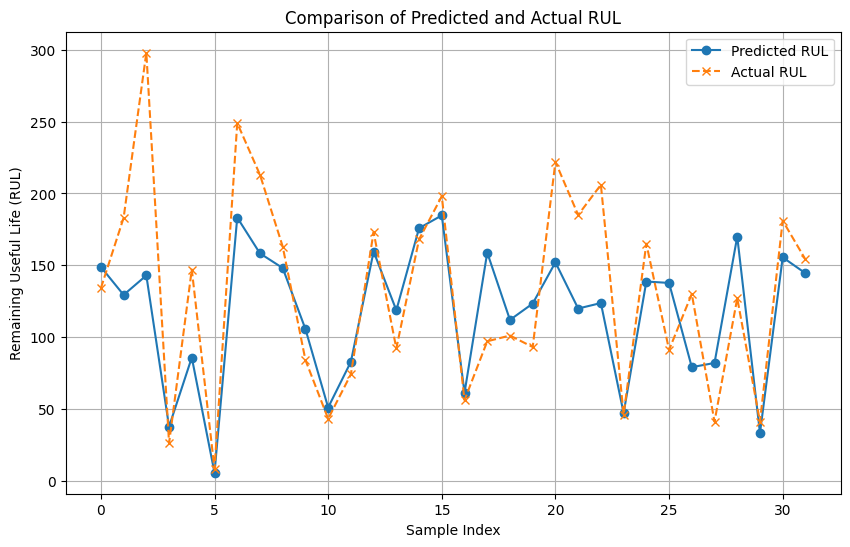

In [31]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Huấn luyện mô hình với sequence_length = 30, 50 epochs

In [32]:
# Đưa dataset vào dataloader
dataset = FD002Dataset(df, sequence_length=30)
# Chia tập train và val theo tỉ lệ 80:20
# Tức là dùng ngay 80% dữ liệu để train và 20% dữ liệu để validate và không dùng tập test
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sau khi tiền xử lý data thì còn 17 cột (do bỏ đi các cột không cần thiết (sensor 1,5,6...))
# Loại bỏ đi cột  ID Engine, Cycle, Remaining RUL trong FD002Dataset, RUl là đầu ra nên cần bỏ đi, và không được đưa vào mô hình (ban đầu có 17 dim)
input_dim = 24
# Ngoài input_dim=14 ra, thì các tham số các này có thể thay đổi. các tham số còn lại có thể thay đổi tùy thuộc vào mô hình
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(device)

# hàm mất mát được dùng là hàm MSELoss (Mean Squared Error Loss)
criterion = nn.MSELoss()
# Hàm tối ưu là hàm Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop (50 Epochs)
for epoch in range(50):
    model.train()
    train_loss = 0
    for batch in train_loader:
        seq, target = batch
        seq, target = seq.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)
            output = model(seq)
            loss = criterion(output, target)
            val_loss += loss.item()
    
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(val_loader)}")

Epoch 1: Train Loss = 0.03161785712910359, Val Loss = 0.013381978511410705
Epoch 2: Train Loss = 0.01615488410292509, Val Loss = 0.011698223452267453
Epoch 3: Train Loss = 0.014364922698345486, Val Loss = 0.016052865613393717
Epoch 4: Train Loss = 0.013219187206147193, Val Loss = 0.011662016990095067
Epoch 5: Train Loss = 0.013062236744388422, Val Loss = 0.01101482106746532
Epoch 6: Train Loss = 0.01281957101007556, Val Loss = 0.019537442682832994
Epoch 7: Train Loss = 0.01261288618183917, Val Loss = 0.01576813959087983
Epoch 8: Train Loss = 0.012479503712758654, Val Loss = 0.011010556691245637
Epoch 9: Train Loss = 0.012227131167803745, Val Loss = 0.011663240292770176
Epoch 10: Train Loss = 0.012166440433735564, Val Loss = 0.010961775337652042
Epoch 11: Train Loss = 0.012106462118737915, Val Loss = 0.011072974136440811
Epoch 12: Train Loss = 0.012120969399566533, Val Loss = 0.011115679562504316
Epoch 13: Train Loss = 0.011782231454046244, Val Loss = 0.011123248778773426
Epoch 14: Trai

In [34]:
# Lấy một vài mẫu dữ liệu từ tập val_loader
samples, targets = next(iter(val_loader))  # Lấy một batch từ validation set
samples, targets = samples.to(device), targets.to(device)

# Dự đoán với model
model.eval()
with torch.no_grad():
    predictions = model(samples)  # [batch_size]

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

In [35]:
# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min


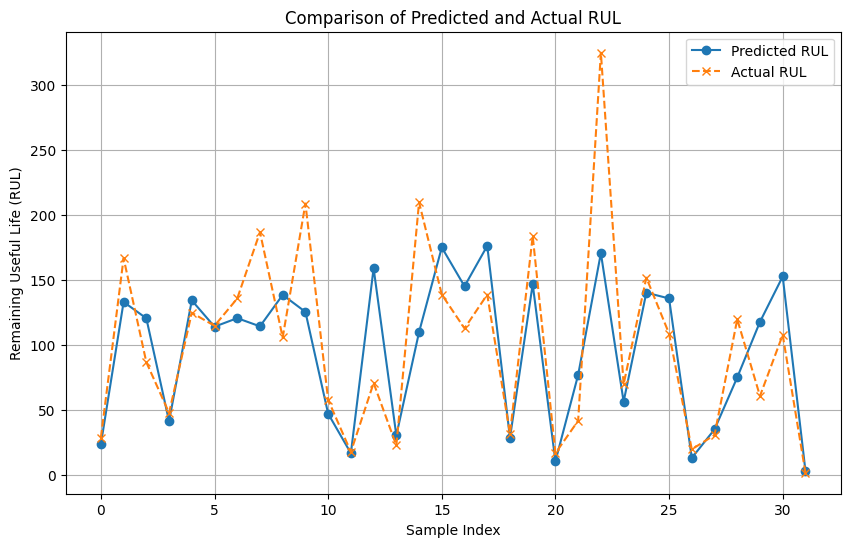

In [36]:
# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## 

In [37]:
# import shap 
# shap.__version__

In [38]:
# samples, targets = next(iter(val_loader))
# print(samples[1].__len__())

In [39]:
# # Define a wrapper to explain the Transformer model
# class TransformerWrapper:
#     def __init__(self, model):
#         self.model = model

#     def __call__(self, inputs):
#         # Convert inputs to tensor if not already
#         if not isinstance(inputs, torch.Tensor):
#             inputs = torch.tensor(inputs, dtype=torch.float32)
#         inputs = inputs.to(device)  # Send to the same device as the model
#         with torch.no_grad():
#             outputs = self.model(inputs)
#         return outputs.cpu().numpy()

In [40]:
# # Instantiate the wrapper
# explainer_model = TransformerWrapper(model)

# sample_data = samples[0]
# sample_data = sample_data.numpy()

# # Ensure sample_data and baseline have correct dimensions
# baseline = np.mean(sample_data, axis=0, keepdims=True)  # Mean across batch
# baseline = baseline[np.newaxis, :, :]  # Add batch dimension to ensure 3D shape: [1, seq_len, feature_dim]
# print(f'baseline shape = {baseline.shape}')

# # SHAP explainer (Kernel SHAP for simplicity)
# explainer = shap.KernelExplainer(explainer_model, baseline)

# # Generate SHAP values
# shap_values = explainer.shap_values(sample_data)
# print(f'shap values = {shap_values.shape}')

In [41]:
# print(f'shap values = {shap_values.shape}')
# shap.summary_plot(shap_values, sample_data)